In [1]:
import statsmodels.discrete.count_model as smdc

import numpy as np
import pandas as pd
import pymc
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az

In [2]:
class DataSet(dict):
    def __init__(self, path):
        print('initializing dataset')
        self.filepath = path
        self.parquet = pq.ParquetFile(self.filepath)
    
    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

    def __reduce__(self):
        #return self.parquet.read().to_pandas().__reduce__()
        return (self.__class__, (self.filepath, ))


def poisson_model(counts_parq, patsy_formula):
    counts_model_poisson = smdc.GeneralizedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_poisson

def zi_poisson_model(counts_parq, patsy_formula):
    counts_model_zi_poisson = smdc.ZeroInflatedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_zi_poisson

def negative_binomial_model(counts_parq, patsy_formula):
    counts_model_negative_binomial = smdc.NegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_negative_binomial

def zi_negative_binomial_model(counts_parq, patsy_formula):
    counts_model_zi_negative_binomial = smdc.ZeroInflatedNegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_zi_negative_binomial

def get_stats(fit_model):
    print('getting stats')
    # available stats come from here https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.CountResults.html

    aic = fit_model.aic
    bic = fit_model.bic
    loglike = fit_model.llf
    llr_chi2 = fit_model.llr
    llr_chip = fit_model.llr_pvalue
    pseudr = fit_model.prsquared
    resid = fit_model.resid
    converged = fit_model.converged

    return [converged, aic, bic, loglike, llr_chi2, llr_chip, pseudr] # list(resid)

# ZINB

In [20]:
name = 'ZINB'
ndraws = 500000
psi = 0.5
mu = 1
alpha = 1
random_seed = 18
name='ZINB'

In [23]:
zinb = pymc.ZeroInflatedNegativeBinomial.dist(psi=psi, mu = mu, alpha = alpha)
zinb_draws = pymc.draw(zinb, draws=ndraws, random_seed=random_seed)

df = pd.DataFrame({'y': zinb_draws})

## trying out Bambi

In [25]:
model = bmb.Model("y~1", df, family="zero_inflated_negativebinomial")
model_fit = model.fit(cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, psi, Intercept]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1067 seconds.


In [ ]:
az.summary(model_fit)

In [ ]:
az.plot_trace(model_fit, compact=False)

## statsmodels, old not working great

In [133]:
model = smdc.ZeroInflatedNegativeBinomialP(endog = zinb_draws, exog = xvar)
model_fit = model.fit(maxiter=500)
model_fit.summary2()

Optimization terminated successfully.
         Current function value: 0.908222
         Iterations: 28
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: ZeroInflatedNegativeBinomialP
===============================================================================
Model:              ZeroInflatedNegativeBinomialP Pseudo R-squared: 0.000      
Dependent Variable: y                             AIC:              908227.6316
Date:               2024-10-17 09:01              BIC:              908260.9987
No. Observations:   500000                        Log-Likelihood:   -4.5411e+05
Df Model:           0                             LL-Null:          -4.5411e+05
Df Residuals:       499999                        LLR p-value:      nan        
Converged:          1.0000                        Scale:            1.0000     
Method:             MLE                                                        
----------------------------------------------------------------------------------
                     Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
----------------------------------------------------------------------------------
inflate_const       -0.0447      0.0201    -2.2273    0.0259    -0.0840    -0.0054
const               -0.0244      0.0101    -2.4107    0.0159    -0.0442    -0.0046
alpha                1.0495      0.0244    43.0049    0.0000     1.0016     1.0973
===============================================================================

"""

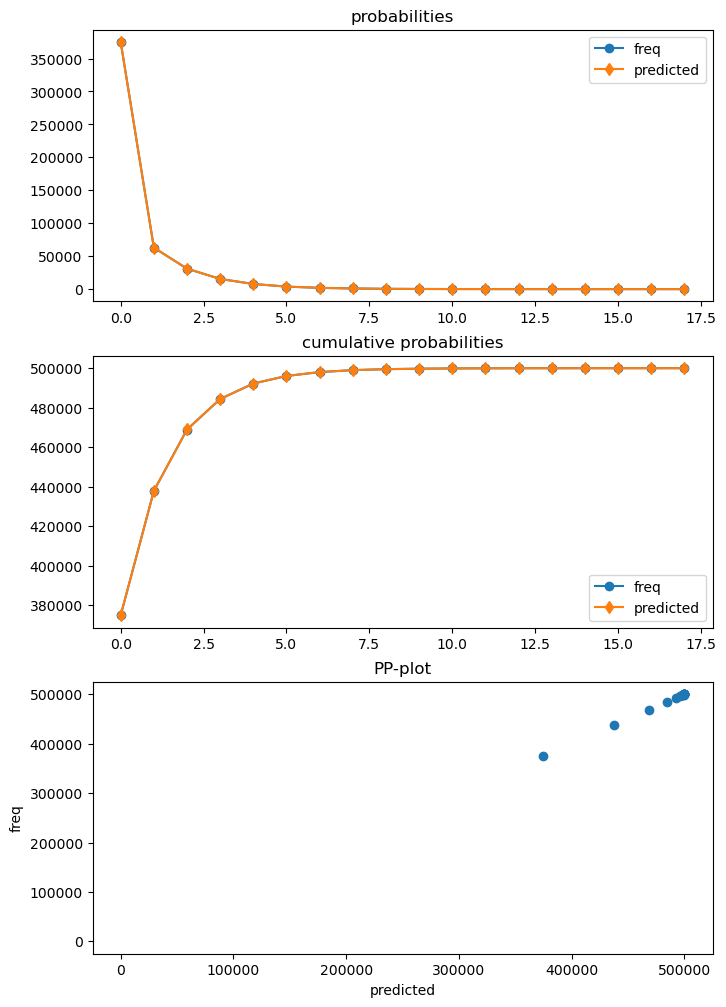

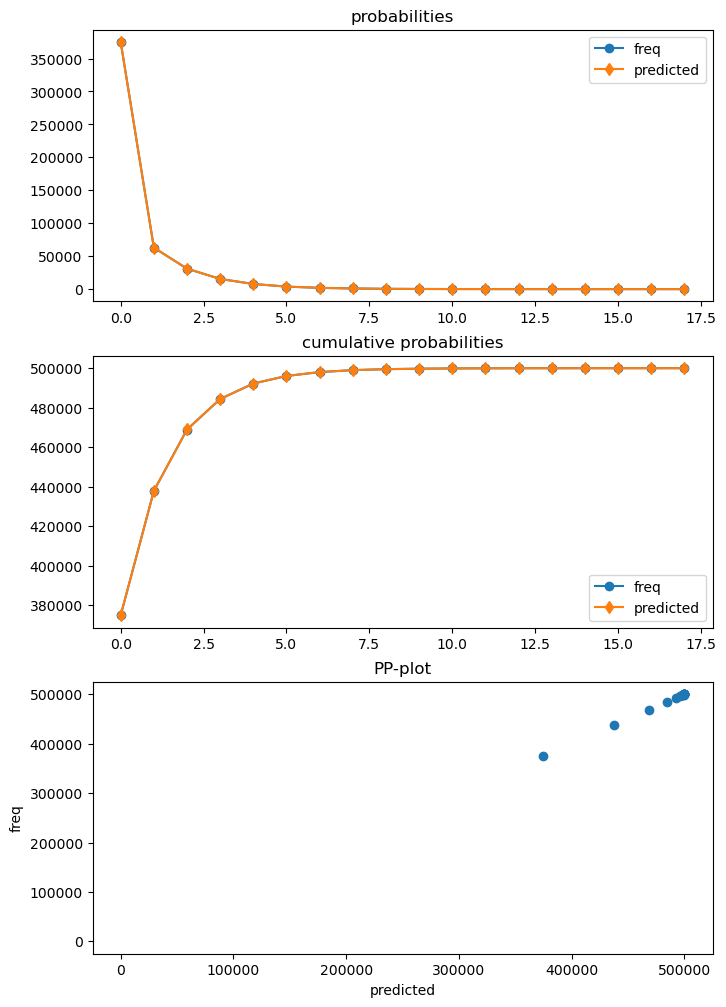

In [134]:
diag = model_fit.get_diagnostic()
diag.plot_probs()

In [137]:
model

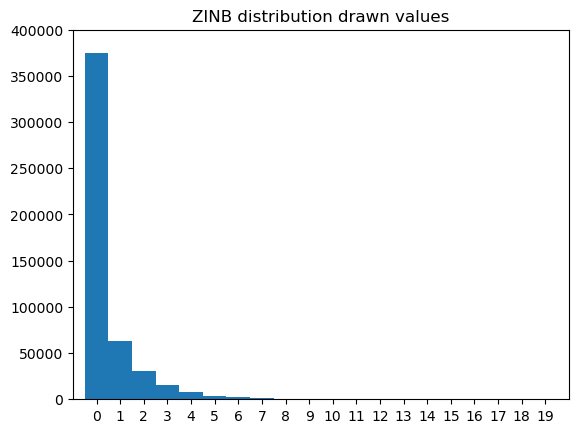

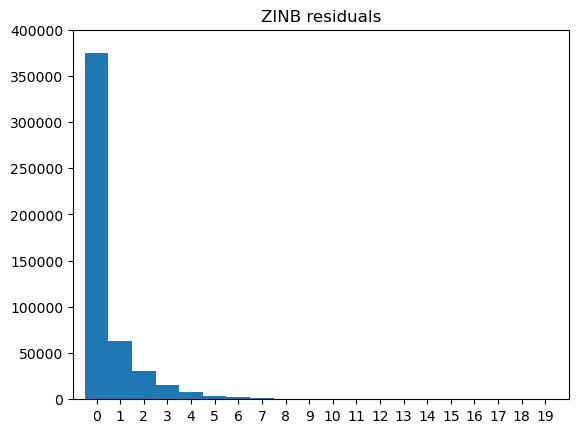

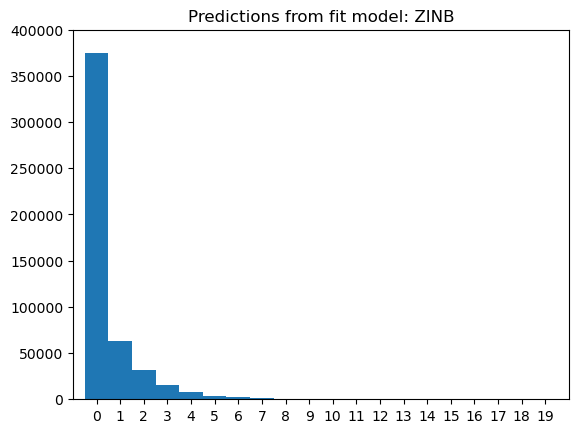

In [135]:
bins = np.arange(21) - 0.5



plt.hist(zinb_draws, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,400000])
plt.title('%s distribution drawn values' % name)
plt.show()

plt.hist(model_fit.resid, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,400000])
plt.title('%s residuals' % name)
plt.show()

plt.hist(model_fit.get_distribution().rvs(), bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,400000])
plt.title('Predictions from fit model: %s' % name)
plt.show()

In [136]:
np.unique(model_fit.resid, return_counts=True)

(array([-0.49885135,  0.50114865,  1.50114865,  2.50114865,  3.50114865,
         4.50114865,  5.50114865,  6.50114865,  7.50114865,  8.50114865,
         9.50114865, 10.50114865, 11.50114865, 12.50114865, 13.50114865,
        14.50114865, 15.50114865, 16.50114865]),
 array([374949,  62964,  31034,  15444,   7861,   3800,   1977,    992,
           484,    244,    121,     69,     38,     13,      3,      4,
             1,      2]))

# NB

In [3]:
ndraws = 500000
mu = 1
alpha = 1
random_seed = 18
name='NB'

In [4]:
nb = pymc.NegativeBinomial.dist(mu = mu, alpha = alpha)
nb_draws = pymc.draw(nb, draws=ndraws, random_seed=random_seed)

df = pd.DataFrame({'y': nb_draws})

## trying out Bambi

In [11]:
model = bmb.Model("y~1", df, family="negativebinomial")
model_fit = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.


In [12]:
az.summary(model_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.988,0.005,0.980,0.997,0.0,0.0,3640.0,3012.0,1.0
Intercept,0.001,0.002,-0.003,0.005,0.0,0.0,3781.0,2254.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

<Figure size 2000x1000 with 0 Axes>

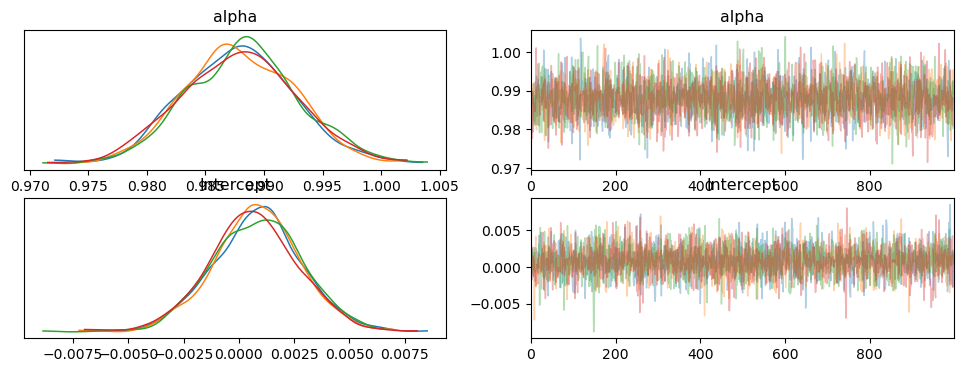

In [19]:

az.plot_trace(model_fit, compact=False)

## statsmodels old stuff

In [38]:
model = smdc.NegativeBinomialP(endog = nb_draws, exog = xvar)
model_fit = model.fit(maxiter=500)
model_fit.summary()

Optimization terminated successfully.
         Current function value: 1.386852
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomialP Regression Results                     
==============================================================================
Dep. Variable:                      y   No. Observations:               500000
Model:              NegativeBinomialP   Df Residuals:                   499999
Method:                           MLE   Df Model:                            0
Date:                Wed, 16 Oct 2024   Pseudo R-squ.:               9.589e-11
Time:                        13:50:21   Log-Likelihood:            -6.9343e+05
converged:                       True   LL-Null:                   -6.9343e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.406      0.685      -0.003       0.005
alpha          1.0123      0.005    203.874      0.000       1.003       1.022
==============================================================================
"""

In [39]:
model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: NegativeBinomialP
====================================================================
Model:              NegativeBinomialP Pseudo R-squared: 0.000       
Dependent Variable: y                 AIC:              1386856.2615
Date:               2024-10-16 13:50  BIC:              1386878.5062
No. Observations:   500000            Log-Likelihood:   -6.9343e+05 
Df Model:           0                 LL-Null:          -6.9343e+05 
Df Residuals:       499999            LLR p-value:      nan         
Converged:          1.0000            Scale:            1.0000      
Method:             MLE                                             
-----------------------------------------------------------------------
          Coef.     Std.Err.       z        P>|z|      [0.025    0.975]
-----------------------------------------------------------------------
const     0.0008      0.0020      0.4057    0.6850    -0.0031    0.0047
alpha     1.0123      0.0050    203.8736    0.0000     1.0025    1.0220
====================================================================

"""

In [130]:
model_fit.resid

array([-1.000814e+00, -1.000814e+00,  9.991860e-01, ...,  6.999186e+00,
       -1.000814e+00, -8.140000e-04])

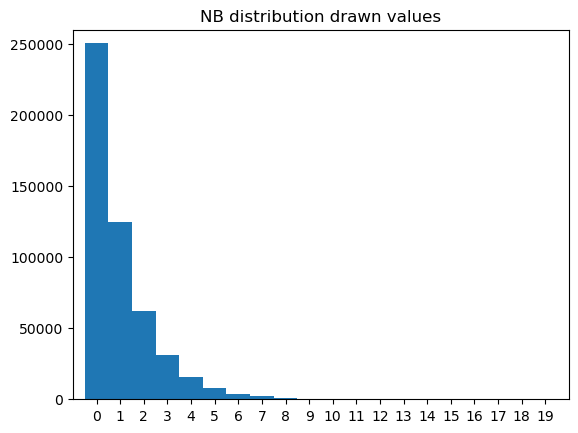

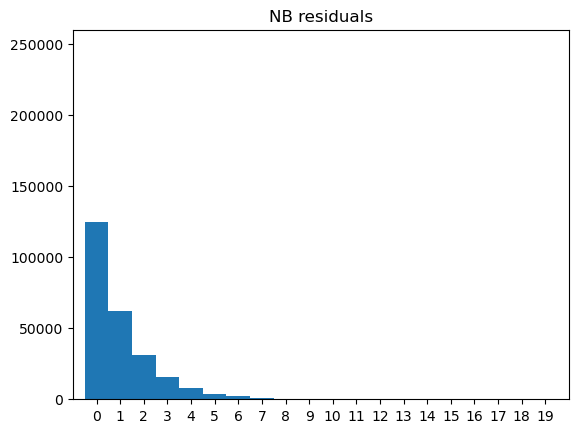

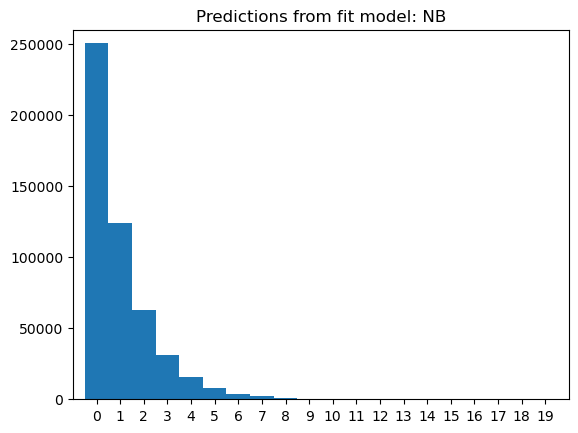

In [270]:
bins = np.arange(21) - 0.5

plt.hist(nb_draws, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,260000])
plt.title('%s distribution drawn values' % name)
plt.show()

plt.hist(model_fit.resid, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,260000])
plt.title('%s residuals' % name)
plt.show()

plt.hist(model_fit.get_distribution().rvs(), bins = bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,260000])
plt.title('Predictions from fit model: %s' % name)
plt.show()

In [269]:
model_fit.prsquared

9.58884083246403e-11

In [23]:
model.loglike(model_fit.params)

-693426.1307369282